#Model Build - Fast Hyper Parameter Search
Building and testing models notebook for Google Colab

The gridsearch was taking way too long. This script now includes a function that searches over the hyperparemeters far more rapidly. Its not as thorough but given what we saw last time, it doesnt need to be.

This was primarily used to create optimised models for the weather variables besides temperature.

For more thorough commentary, please see model_build_smooth.


Be sure to switch to GPU in the run time


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from scipy.ndimage import gaussian_filter1d

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#my file path to data on Gdrive
! ls drive/MyDrive/0_neural_net_weather_forecasts_on_cloud/Data

best_humidity_model.h5	   records_1622140823.csv
best_precip_model.h5	   records_1622141750.csv
best_temp_model.h5	   results_table_1621536110.csv
best_temp_smooth_model.h5  results_table_1621583745.csv
humidity_model.h5	   results_table_1621688232.csv
precip_model.h5		   results_table_1621765059.csv
records_1621964476.csv	   results_table_temp.csv
records_1621964569.csv	   results_table_temp_smooth.csv
records_1621966077.csv	   temp_model.h5
records_1621974614.csv	   weather_data.csv
records_1621974753.csv	   windspeed_model.h5
records_1621976105.csv


In [ ]:
os.chdir('drive/MyDrive/0_neural_net_weather_forecasts_on_cloud/Data')

In [ ]:
df = pd.read_csv('weather_data.csv')

#get time
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y')
df = df.set_index('datetime')

print(df.columns)

Index(['datetimeEpoch', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunriseEpoch',
       'sunset', 'sunsetEpoch', 'moonphase', 'conditions', 'description',
       'icon', 'stations', 'source', 'tzoffset'],
      dtype='object')


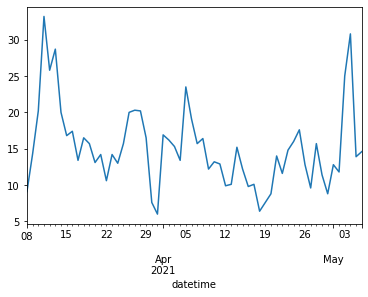

In [ ]:
#get windspeed
wind = df['windspeed']

#split data (Save a week for testing. Train and Validation made in class)
wind_train = wind.iloc[:-7]
wind_test = wind.iloc[-7:]


#inspect
wind_train.iloc[-60:].plot()

##Define the model class

In [ ]:
class BuildModel():
    """
    Build a model. Arguments allow one to customise the hyper parameters
    ATTRIBUTES :- 
    length - number of steps in time sequence to feed the rnn
    layers_num - number of rnn layers in model (capped at 3)
    layers_type - select "LSTM" or "GRU"
    units - number of units in rnn layers
    num_step_preds - number of steps/days in time to predict
    dropout - dropout % to be applied to rnn units
    g_filt - gaussian filter for smoothing. Default: no smoothing
    batch_size - number of samples to feed model at a time.
    patience - how many epochs to wait before stopping model after finding good score.
    model_name - file name of model we save. must end in ".h5" eg 'temp_model.h5'
    """
    def __init__(self, model_name, length=10, layers_num=1, layers_type='LSTM',\
                 units=50, dropout=0.0, g_filt=00.1, num_step_preds=1,\
                 epochs=8, batch_size=1, patience=5):
        
        #assertions for input
        assert 0 < layers_num < 4, "1 <= layers_num <= 3"
        assert layers_type in ['LSTM', 'GRU'], "layers_type is LSTM or GRU"
        assert 0 <= dropout < 1, "dropout must be float < 1"
        assert model_name[-3:] == '.h5', "End model_name with '.h5'"
        
        #initialise
        self.model_name = model_name        
        self.length = length
        self.layers_num = layers_num
        self.layers_type = layers_type
        self.units = units
        self.num_step_preds = num_step_preds
        self.dropout = dropout
        self.g_filt = g_filt
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_features = 1
        
        #callbacks
        self.callbacks =[EarlyStopping(monitor='val_loss', patience=patience),\
                         ModelCheckpoint(self.model_name, monitor='val_loss',\
                                         save_best_only=True)]
        
        #BUILD MODEL
        ##inputs
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(self.length, self.n_features)))
        
        ##add extra layers as required (or not if layers_num = 1)
        for i in range(layers_num - 1):
            self.model.add(eval('{}(units={}, dropout={}, return_sequences=True)'\
                .format(self.layers_type, self.units, self.dropout)))
                
        ##closing rnn layer (do not return squences)
        self.model.add(eval('{}(units={}, dropout={})'\
                .format(self.layers_type, self.units, self.dropout)))
            
        ##Dense output
        self.model.add(Dense(units=self.num_step_preds))
                       
        #compile model
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    def setupData(self, series, val_days=450):
        """
        splits data, scales data, creates generators for the model
        """
        assert val_days > self.length , "val_days must exceed lenght"
        
        #split data into train and validation
        self.train = series.iloc[:-val_days]
        self.validation = series.iloc[-val_days:]
        
        #Apply smoothing filters  
        self.train_smooth = \
             gaussian_filter1d(self.train, self.g_filt)\
                 .reshape(-1,1)
            
        self.validation_smooth = \
             gaussian_filter1d(self.validation, self.g_filt)\
                 .reshape(-1,1)

        #create time series generators
        self.generator = \
             TimeseriesGenerator(data=self.train_smooth,\
                                 targets=self.train_smooth,\
                                 length=self.length,\
                                 batch_size=self.batch_size)
                 
        self.val_generator = \
             TimeseriesGenerator(data=self.validation_smooth,\
                                 targets=self.validation_smooth,\
                                 length=self.length,\
                                 batch_size=self.batch_size)                 

    def fitModel(self):
        """
        Fits the model on your generators for training and validation sets.
        EarlyStopping call back ends training if val_loss doesnt improve.
        Record epoch metrics in a DataFrame.
        """
        self.model.fit(self.generator, validation_data=self.val_generator,\
                       epochs=self.epochs, callbacks=self.callbacks)
            
        self.history = pd.DataFrame(self.model.history.history)
        
    def loadModel(self):
        """
        Load a model instead of fitting a new one (uses model_name)
        """
        self.model = tf.keras.models.load_model(self.model_name)
            
    def predAhead(self, days, series=None):
        """
        Predicts a number of days ahead set by the user. Input your own
        series or dont if you want to predict off of the validation set.
        """
        assert self.num_step_preds == 1,\
            "sorry, function not yet available for multi step models"
        
        #use end of the validation set to project forward if no series given
        if series is None:
            series = self.validation
        
        #get end of the series to plug into the model
        assert len(series) >= self.length,\
            "series must be at least {} days".format(self.length)
            
        series_cut = series.iloc[-self.length:].values.reshape(-1,1)
            
        #predict ahead by appending predictions and removing first values
        pred_series = series_cut.reshape(1, self.length, self.n_features)

        predictions = []
        
        for i in range(days):
            pred = self.model.predict(pred_series)
            pred_series = np.append(pred_series[:,1:,:], [pred], axis=1)
            predictions.append(pred)
                    
        #convert to pandas series
        predictions = np.array(predictions)
        predictions = pd.Series(predictions.reshape(days))
        predictions.index = self.validation.index[-days:] +\
                                 dt.timedelta(days=days)
            
        return predictions
    
    def plotPreds(self, predictions, test_series=None, run_up=None,\
                  ylabel='units'):
        """
        plot the predictions of the model. plot them against another series
        (test series). plot with with a run up leading to the pred period
        (validation set).
        """
        #set up figure
        plt.figure(figsize=(10,6))
        plt.ylabel(ylabel)
        plt.xlabel('datetime')
        
        #plot lines
        if run_up is None:
            run_up = self.validation[-7:]
            
        if test_series is not None:
            plt.plot(pd.concat([run_up, test_series[:1]]))
            plt.plot(test_series)
            
        else:
            plt.plot(run_up)
            
        #plot points
        plt.scatter(predictions.index, predictions, edgecolors='k',\
                    label='predictions', c='#2ca02c', s=64)
            
        if test_series is not None:
            plt.scatter(test_series.index, test_series, marker='X',\
                        edgecolors='k', label='test_data', c='#ff7f0e', s=200)
                
        plt.legend()


In [ ]:
def fastSearch(data: pd.Series, length: list, layers_num: list,\
               layers_type: list, units: list, g_filt: list, model_name: str,\
               best_dict=None):
    """
    First it will set all hyperparameters to their first value in the lists we
    pass in.
    Then list by list it will train the model, keeping the best performing
    element in that list.
    Its recommended that you pass in the resulting dictionary into this 
    function a second time.
    """
    #record time for file_name
    time_now = str(round(time.time()))
    
    #set initial values if no specified parameters given.
    if best_dict is None:
        best_dict = {}
        
        best_dict['length'] = [length[0], length]
        best_dict['layers_num'] = [layers_num[0], layers_num]
        best_dict['layers_type'] = [layers_type[0], layers_type]
        best_dict['units'] = [units[0], units]
        best_dict['g_filt'] = [g_filt[0], g_filt]
    
    records = pd.DataFrame()
    
    #go through each hyperparameter
    for key in best_dict.keys():
        if len(best_dict[key][1]) == 0:
            continue
        
        scores = []
        
        #go through each value
        for item in best_dict[key][1]:
            best_dict[key][0] = item
            
            model = \
                BuildModel(model_name=model_name,\
                           length=best_dict['length'][0],\
                           layers_num=best_dict['layers_num'][0], \
                           layers_type=best_dict['layers_type'][0],\
                           units=best_dict['units'][0],\
                           g_filt=best_dict['g_filt'][0], num_step_preds=1,\
                           epochs=120, batch_size=10, patience=15)
                    
            #setup data and train the model
            model.setupData(data)
            model.fitModel()
                         
            #calculate val_mae in unsmoothed original units
            best_model = tf.keras.models.load_model(model_name)
            preds = best_model.predict(model.val_generator)
            preds = pd.Series(preds[:,0],\
                        index = model.validation[model.length:].index)
        
            val_mae_og = (preds - model.validation[model.length:]).abs()\
                         .mean()
            
            record = pd.DataFrame(best_dict).iloc[:1] 
            record['val_mae_og'] = val_mae_og
            
            #append score
            scores.append(val_mae_og)
            records = records.append(record)
            records.to_csv('records_' + time_now + '.csv', index=False)
            
        #get param value that performed the best
        best_score = min(scores)
        best_dict[key][0] = best_dict[key][1][scores.index(best_score)]
        
    return records, best_dict

##Use functions and class to optimise a model

In [ ]:
length = [15, 30, 60]
layers_num = [1, 2]
layers_type = ['LSTM']
units = [20, 40, 80] 
g_filt = [0.5, 0.75, 1.0, 1.25]

model_name = 'windspeed_model.h5'

records, best_dict = fastSearch(wind_train, length, layers_num, layers_type, units, g_filt, model_name=model_name, best_dict=None)
records2, best_dict2 = fastSearch(wind_train, length, layers_num, layers_type, units, g_filt, model_name=model_name, best_dict=best_dict)

records_all = pd.concat([records,records2])

Epoch 1/120
193/193 [==============================] - 9s 6ms/step - loss: 102.9898 - mae: 8.5735 - val_loss: 82.2140 - val_mae: 7.9981
Epoch 2/120
193/193 [==============================] - 1s 4ms/step - loss: 36.6651 - mae: 4.6356 - val_loss: 38.9598 - val_mae: 4.9047
Epoch 3/120
193/193 [==============================] - 1s 4ms/step - loss: 20.6372 - mae: 3.2892 - val_loss: 25.2359 - val_mae: 3.8174
Epoch 4/120
193/193 [==============================] - 1s 4ms/step - loss: 15.9589 - mae: 2.8945 - val_loss: 20.5559 - val_mae: 3.4515
Epoch 5/120
193/193 [==============================] - 1s 4ms/step - loss: 13.7239 - mae: 2.6912 - val_loss: 17.5182 - val_mae: 3.1843
Epoch 6/120
193/193 [==============================] - 1s 4ms/step - loss: 12.2725 - mae: 2.5679 - val_loss: 15.4971 - val_mae: 3.0199
Epoch 7/120
193/193 [==============================] - 1s 4ms/step - loss: 11.4784 - mae: 2.4965 - val_loss: 14.5550 - val_mae: 2.9185
Epoch 8/120
193/193 [==============================] -

## Analyse the Grid Search Results

In [ ]:
#load it from drive
records = pd.read_csv('records_1622140823.csv')
records2 = pd.read_csv('records_1622141750.csv')

gs = pd.concat([records,records2])

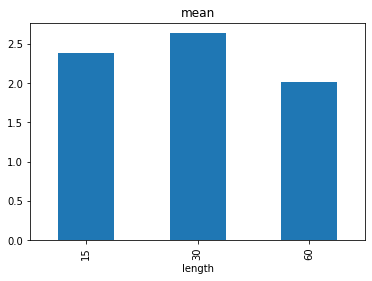

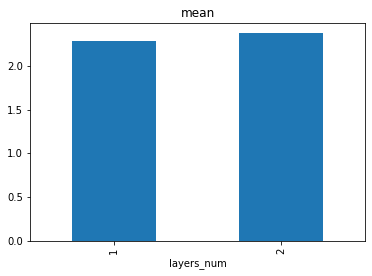

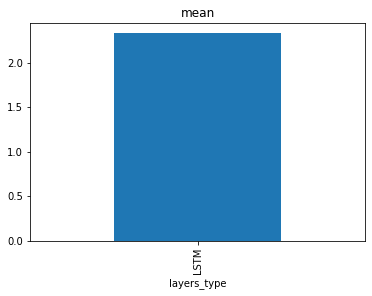

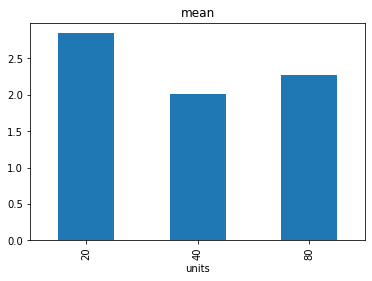

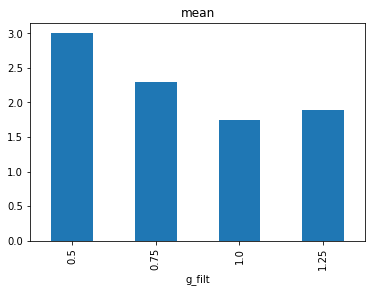

In [ ]:
gs.groupby('length')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('layers_num')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('layers_type')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('units')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('g_filt')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()

COMMENTARY

Not too disimlar to the temp model, though it does better with longer series fed into it.

## Recreate the best model and compare against test data

In [ ]:
best_model_params = gs.sort_values('val_mae_og').iloc[0]
best_model_params

length              60
layers_num           2
layers_type       LSTM
units               40
g_filt               1
val_mae_og     1.70833
Name: 2, dtype: object

In [ ]:
best_model = BuildModel(model_name='best_windspeed_model.h5', length=30, layers_num=2,\
                        layers_type='LSTM', units=40, dropout=0, g_filt=1, epochs=120, batch_size=10,\
                        patience=15)

best_model.setupData(wind_train)
best_model.fitModel()

Epoch 1/120
192/192 [==============================] - 10s 9ms/step - loss: 37.4656 - mae: 4.6899 - val_loss: 17.9815 - val_mae: 3.2083
Epoch 2/120
192/192 [==============================] - 1s 6ms/step - loss: 11.5541 - mae: 2.5000 - val_loss: 12.2173 - val_mae: 2.6916
Epoch 3/120
192/192 [==============================] - 1s 6ms/step - loss: 10.2739 - mae: 2.3612 - val_loss: 11.1192 - val_mae: 2.5786
Epoch 4/120
192/192 [==============================] - 1s 6ms/step - loss: 7.7690 - mae: 1.9924 - val_loss: 7.4730 - val_mae: 2.0345
Epoch 5/120
192/192 [==============================] - 1s 6ms/step - loss: 4.6155 - mae: 1.4407 - val_loss: 4.4471 - val_mae: 1.4694
Epoch 6/120
192/192 [==============================] - 1s 6ms/step - loss: 2.8746 - mae: 1.0921 - val_loss: 2.7667 - val_mae: 1.1107
Epoch 7/120
192/192 [==============================] - 1s 6ms/step - loss: 1.9913 - mae: 0.8872 - val_loss: 2.0369 - val_mae: 0.9514
Epoch 8/120
192/192 [==============================] - 1s 6ms/

In [ ]:
#load best performer
best_model.loadModel()

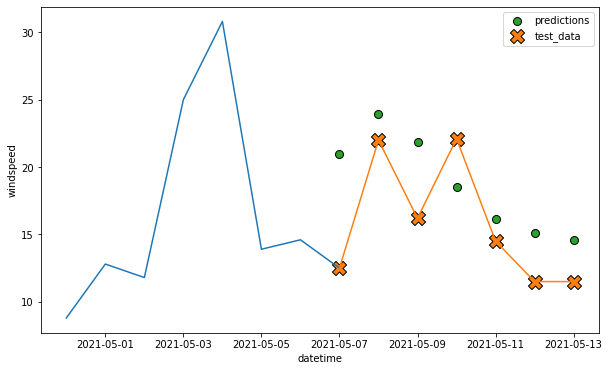

In [ ]:
#predict a week
week_pred = best_model.predAhead(7)

#plot against test week
best_model.plotPreds(week_pred, wind_test, ylabel='windspeed')

COMMENTARY

First pred is a fair bit off. Rest of the series looks okay.